In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import integrate

import sys, os, glob, copy

sys.path.append("/cluster/home/cchampion/programs/PyGromosTools3")
import pygromos

from pygromos.files.trajectory.trg import Trg

In [23]:
root_dir = '/cluster/home/cchampion/work/REEDS/NIK/TI_comparison/openff_repexTI'

leg = '1_6'

sim_dir = root_dir + '/leg_' + leg + '/seed1/simulation'
data_dir = root_dir + '/leg_' + leg + '/seed1/results'

#1 Extract the relevant data from the files



# There will be n_lambda * number of chunks files 
trgs = glob.glob(sim_dir+'/*/*.trg.gz')
sorted_trgs = sort_trgs(trgs)

#dh_dl_avgs, dh_dl_stds = extract_dh_dl_data(sorted_trgs)

# Save the data for easier retrieval. 

#np.save(data_dir+'/avg_dh_dl.npy', dh_dl_avgs)
#np.save(data_dir+'/std_dh_dl.npy', dh_dl_stds)

# If data already exsists, retrive it instead:

dh_dl_avgs = np.load(data_dir+'/avg_dh_dl.npy') 
dh_dl_stds = np.load(data_dir+'/std_dh_dl.npy') 

lambdas = np.arange(0, 1.01, 0.05)
avg_dhdl = integrate_from_averaged_values(lambdas, dh_dl_avgs, dh_dl_stds, data_dir, color = 'firebrick')

# Plot a convergence plot? (with 1 seed doesn't really look as nice and we can just read the file)

#names = path.split('/')


['', 'cluster', 'home', 'cchampion', 'work', 'REEDS', 'NIK', 'TI_comparison', 'openff_repexTI', 'leg_1_6', 'seed1', 'results']
saving to: /cluster/home/cchampion/work/REEDS/NIK/TI_comparison/openff_repexTI/leg_1_6/seed1/results/ti_profile.png


In [40]:
np.amax(all_avgs)

-190.51

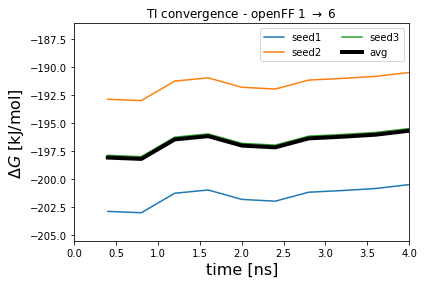

array([0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ])

In [58]:
all_avgs = np.array([avg_dhdl, avg_dhdl+ 10, avg_dhdl+5])
lambdas = np.arange(0, 1.01, 0.05)

convergence_analysis(lambdas, all_avgs, leg_dir=None, max_t = 4, leg = '1_6')
time

In [57]:
def convergence_analysis(lambdas, all_dhdls, results_dir, max_t, leg, reeds_val = None):
        num_seeds = len(all_dhdls)
        
        avg_dh_dls = np.average(all_dhdls, axis=0)
        
        # Plot the data
        
        # Draw a dashed line for the RE-EDS result
        if reeds_val is not None: 
            plt.axhline(y=reeds_val, color = 'darkgrey', linestyle = '--', label = 're-eds')
        
        time = np.arange(0, max_t, max_t/10) + max_t/10
        
        for i in range(num_seeds):
            plt.plot(time, all_dhdls[i], label = 'seed' + str(i+1))
        
        plt.plot(time, avg_dh_dls-0.2, label = 'avg', color = 'black', lw = 4)
        
        plt.xlabel('time [ns]', fontsize = 16)
        plt.xlim(0, max_t)
    
        plt.ylabel(r' ${\Delta G}$ [kJ/mol]  ', fontsize = 16)
        
        # Select some proper size for the plot
        
        amin = np.amin(all_dhdls)
        amax = np.amax(all_dhdls)
        data_range = amax - amin
        
        # To make plot breathe
        plt.ylim([amin-0.2*data_range, amax+0.35*data_range])
        
        
        plt.legend(loc='upper right', ncol=2)
        
        leg = leg.split('_')
        plt.title('TI convergence - openFF ' + leg[0] + r' $\rightarrow{}$ ' + leg[-1])
        
        plt.savefig(results_dir+ '/ti_convergence.png', dpi=300)
                
        plt.show()
        return

### Functions doing the work

In [11]:
def sort_trgs(trgs, num_lambdas=21, num_chunks=10):
    """
    This function will sort the list of trgs extracted from the directory. 
    It will remove the files that were for the equilibration.
    
    It will make a list of lists of files. 
    
    Outer list indexes each lambda, and then inner list indexes the chuncks for that lambda 
    """
    path_to_data = []
    x = [[]] * num_chunks 
    for i in range(num_lambdas): path_to_data.append(copy.deepcopy(x))
    
    for trg in trgs:
        fpath, fname = os.path.split(trg)
        if 'eq_' in fname: continue       
        i, j = (fname.split('.')[0].split('_')[-2:])
        # Add to the correct place
        path_to_data[int(j)-1][int(i)-1] = trg
        #print (i) # for chunck
        #print (j) # for lambda  
    return path_to_data
    
def extract_dh_dl_data(sorted_trgs, n_chunks = 8, chunks_convergence=10):
    """
    This function will read the data sequentially and append things to the 
    proper numpy arrays.
    
    Here we will already extract averages for chunks of the data (every 10%)
    allowing to perform convergence analysis.
    """
    
    # Here we will get the time axis, and number of data points from first file
    
    template_trg =  Trg(sorted_trgs[0][3])
    
    delta_t = template_trg.database.time[1] - template_trg.database.time[0]
    n_per_chunk = len(template_trg.database.time)
    
    dh_dl_avgs = np.zeros([21, chunks_convergence])
    dh_dl_stds = np.zeros([21, chunks_convergence])
    
    dh_dl_full_timeseries = []
    
    for i, trgs_lambda in enumerate(sorted_trgs):
        
        tmp_dhdl = np.array([])
        
        for j, trg in enumerate(trgs_lambda):
            if trg == []: continue
            # Read in file:
            data = Trg(trg)
            tmp_dhdl = np.append(tmp_dhdl, data.get_totals()["dHdl"]) 
            
        # Add data to full timeseries object
        dh_dl_full_timeseries.append(tmp_dhdl)
        
    # Now that all of the data is loaded in take the averages
    
    size = len(dh_dl_full_timeseries[0])

    conv_slice = np.arange(chunks_convergence, 101, chunks_convergence)
    results = np.zeros([21, len(conv_slice)])

    for i, dhdl_at_lam in enumerate(dh_dl_full_timeseries):
        dh_dl_avgs[i] = np.array([np.average(dhdl_at_lam[:int(j*size/100)]) for j in conv_slice])
        dh_dl_stds[i] = np.array([np.std(dhdl_at_lam[:int(j*size/100)]) for j in conv_slice])
    
    return dh_dl_avgs, dh_dl_stds
    
    

In [5]:
def integrate_from_averaged_values(lambdas, avg_dhdl, stddev_dhdl, results_path, color = 'firebrick'):
    """
        lambdas: List[float]
            list of all lambdas
        data_dhdl: Tuple (List[float], List[float])
            tuple with average and standard deviations of the data
        data_dvdl:Tuple (List[float], List[float])
            tuple with average and standard deviations of the data
        root_dir_ti_leg: str 
            directory to store data in
    """
    # Make an output directory
    if not os.path.isdir(results_path):
        os.mkdir(results_path)
    
    #return avg_dhdl, avg_dvdl
    
    # We can do a convergence analysis of this integral (chuncks we all already printed out)
    integral_dhdl = np.zeros(len(avg_dhdl.T))
        
    for i in range(len(avg_dhdl.T)):
        integral_dhdl[i] = np.round(integrate.simps(x=lambdas, y=avg_dhdl.T[i]),2)

    
    # Write the results to a text file:
    f = open(results_path+'/ti_integral_averaged.txt', 'w')
    f.write('This file contains the TI integral evaluated using the first n% of the data.\n')
    f.write('dH/d(lamda) values used to compute the integral where averaged over 3 random seeds.')
    f.write('\nPercent\tdHdl\tdVdl\n')
    
    
    for i, v1 in enumerate(integral_dhdl):
        percent = str((i+1)/len(integral_dhdl)*100)
        f.write(percent + '%\t'+str(v1)+'\n')
    f.close()
    
    # Plot the TI profile
    plot_TI_profile(lambdas, avg_dhdl.T[-1], stddev_dhdl.T[-1], integral_dhdl[-1], results_path, color = color)
    
    return integral_dhdl

In [20]:
def plot_TI_profile(lambdas, avg_dXdl, std_dXdl, integral_dXdl, path, color = 'firebrick'):
    """
        Plot the TI profile with averaged values
    """
    
    fig, axes = plt.subplots(ncols=1, nrows=1, figsize=[8,6])

    # plot basic data
    plt.errorbar(lambdas, avg_dXdl, std_dXdl, fmt='-', color = color, 
                 ecolor = 'black', elinewidth=1, capsize=2, capthick=1, barsabove=True)

    plt.scatter(lambdas, avg_dXdl, marker='x', color='darkgrey', s=24)

    # Label axes and plot title 

    plt.xlabel(r'$\lambda$', fontsize = 16)
    plt.xlim(0, 1)

    plt.ylabel(r' ${\partial V}$ / ${\partial \lambda}$ [kJ/mol]  ', fontsize = 16)
    plt.ylim(1.25 * min(avg_dXdl), 1.25*max(avg_dXdl))
    
    # Get other names for title of the plot - note this can change depending on path!!!
    names = path.split('/')
        
     
    
    legs = names[-3].split('_')
    
    print (names)   
        
        
    title = 'TI profile - ' + names[-5] + ' ' + names[-4] + ' ' + legs[1] + r'$\rightarrow$ ' + legs[2] 

    plt.title(title, fontsize=16)
    
    # Plot the value of the integral
    
    plt.text(0.5,max(avg_dXdl) * 1.1,r'$\int_{0}^{1} \frac{\partial V}{\partial \lambda}$ ${d\lambda} = %s $ kJ/mol'%integral_dXdl, 
             horizontalalignment='center', verticalalignment='center',fontsize = 12)

    #ax.patch.set_facecolor('white')
    fig.patch.set_facecolor('white')
    plt.savefig(path+'/ti_profile.png', dpi=300)
    
    print ('saving to: '+ path +'/ti_profile.png')
    
    plt.close()
    return None

# Convergence analysis plots

note: just give it with 1 seed as we only have a single random seed 

Here I should make a plot like this in the end with all of the npys


In [7]:
def convergence_analysis(lambdas, seed1, seed2, seed3, leg_dir, reeds_val):
        num_seeds = 3 
        
        integral_dhdl = np.zeros([num_seeds+1, len(seed1.T)])

        data_dh_dl = np.array([seed1, seed2, seed3])
        averaged_dh_dls = np.average(data_dh_dl, axis=0)
        
        #print (averaged_dh_dls)
        
        for i, seed in enumerate([seed1, seed2, seed3, averaged_dh_dls]):
            for j in range(len(seed.T)): # each convergence
                tmp = np.round(integrate.simps(x=lambdas, y=seed.T[j]),2)
                integral_dhdl[i][j] = tmp
                
        
        # Plot the data
        
        # Draw a dashed line for the RE-EDS result
        plt.axhline(y=reeds_val, color = 'darkgrey', linestyle = '--', label = 're-eds')
        
        time = np.arange(0, 19, 1.9) + 1.9
                
        plt.plot(time, integral_dhdl[0], label = 'seed1')
        plt.plot(time, integral_dhdl[1], label = 'seed2')
        plt.plot(time, integral_dhdl[2], label = 'seed3')
        plt.plot(time, integral_dhdl[3], label = 'avg', color = 'black', lw = 4)
        
        plt.xlabel('time [ns]', fontsize = 16)
        plt.xlim(0, 19)
    
        plt.ylabel(r' ${\Delta G}$ [kJ/mol]  ', fontsize = 16)
        
        leg = leg_dir.split('/')[-1].replace('leg_', '')
        
        plt.title('TI convergence - openFF ' + leg[0] + r' $\rightarrow{}$ ' + leg[-1])
        
        plt.legend()

        plt.savefig(leg_dir+'/results/ti_convergence.png', dpi=300)
        
        print ('The results for the three seeds are:')
        print ('seed1: ' + str(integral_dhdl[0][-1]))
        print ('seed2: ' + str(integral_dhdl[1][-1]))
        print ('seed3: ' + str(integral_dhdl[2][-1]))
        print ('avg: ' + str(integral_dhdl[3][-1]))
        
        plt.close()

In [8]:
def standard_dev_dhdl(lambdas, seed1, seed2, seed3, leg_dir):
        
        data_dh_dl = np.array([seed1.T[-1], seed2.T[-1], seed3.T[-1]])
        stddev_dh_dls = np.std(data_dh_dl, axis=0)
        
        # Plot the data
        
        print (stddev_dh_dls)
        
        plt.scatter(lambdas, stddev_dh_dls, label = 'avg', color = 'black')
        
        plt.xlabel(r'$\lambda$', fontsize = 16)
    
        plt.ylabel(r' $\sigma{}  (dH/d\lambda)$ [kJ/mol]  ', fontsize = 16)
        
        leg = leg_dir.split('/')[-1].replace('leg_', '')
        
        plt.title('TI convergence - openFF ' + leg[0] + r' $\rightarrow{}$ ' + leg[-1])
        
        plt.legend()

        plt.savefig(leg_dir+'/results/dh_dl_stddev.png', dpi=300)
        plt.close()